In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
import sys
projectDir = "/content/drive/My Drive/code/git/tweepfake_deepfake_text_detection"
sys.path.insert(0, projectDir)

resultsDir = projectDir+"/data/results"
random_state = 523 # Fixed seed for replicability of randomic operations.

In [ ]:
!pip install pandas

In [ ]:
from DataHandler import DataHandler

csvTrainDataset = projectDir+"/data/splits/train.csv"
csvValDataset = projectDir+"/data/splits/validation.csv"
csvTestDataset = projectDir+"/data/splits/test.csv"




dh = DataHandler()
dfTrain = dh.readCSVData(csvTrainDataset)
dfVal = dh.readCSVData(csvValDataset)
dfTest = dh.readCSVData(csvTestDataset)


In [ ]:
dfTrain

,N_prog,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,is_retweet,favorite_count,retweet_count,quote_count,reply_count,hashtags,symbols,urls_url,urls_t.co,urls_expanded_url,media_url,media_t.co,media_expanded_url,media_type,ext_media_url,ext_media_t.co,ext_media_expanded_url,ext_media_type,mentions_user_id,mentions_screen_name,lang,quoted_status_id,quoted_text,quoted_created_at,quoted_source,quoted_favorite_count,quoted_retweet_count,quoted_user_id,...,place_url,place_name,place_full_name,place_type,country,country_code,geo_coords,coords_coords,bbox_coords,status_url,name,location,description,url,protected,followers_count,friends_count,listed_count,statuses_count,favourites_count,account_created_at,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url,created,data.tweet,ora.tweet,tweet_type,mention_TF,hashtag_TF,url_TF,n.words,punct,account.type,finetuning_source,class_type
0,14692,x1110407881030017024,x1208265880146046976,2019-12-21 06:00:08,imranyebot,YEA now that note GOOD,imranye-twitter-bot,22,NaN,NaN,NaN,False,False,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NA NA,NA NA,NA NA NA NA NA NA NA NA,https://twitter.com/imranyebot/status/12082658...,imranyebot,NaN,@imranye in robot form. tweets every hour gene...,NaN,False,29,3,0,7467,0,2019-03-26 05:07:23,False,NaN,NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/1110408254...,2019-12-21 06:00:08,2019-12-21,06:00:08,tweet,False,False,False,5,0,bot,imranye,others
1,22336,x3171109449,x1091463908118941696,2019-02-01 22:30:48,zawvrk,Listen to This Charming Man by The Smiths htt...,Twitter for iPhone,66,NaN,NaN,NaN,False,False,4,0,NaN,NaN,NaN,NaN,soundcloud.com/thesmiths/this…,https://t.co/r12OIXkfUO,https://soundcloud.com/thesmiths/this-charming...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NA NA,NA NA,NA NA NA NA NA NA NA NA,https://twitter.com/zawvrk/status/109146390811...,zawar,NaN,gold experience,https://t.co/J60plTSsKt,False,558,274,8,12216,23633,2015-04-15 19:50:16,False,https://t.co/J60plTSsKt,https://www.instagram.com/zawvr,NaN,https://pbs.twimg.com/profile_banners/31711094...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1229957200...,2019-02-01 22:30:48,2019-02-01,22:30:48,tweet,False,False,True,13,3,human,original,human
2,24087,x1110686081341632512,x1199055191028293633,2019-11-25 20:00:09,zawarbot,wish i can i would be seeing other hoes on the...,zawar-twitter-bot,57,NaN,NaN,NaN,False,False,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NA NA,NA NA,NA NA NA NA NA NA NA NA,https://twitter.com/zawarbot/status/1199055191...,zawarbot,NaN,I’m an AI Bot that tries to tweet like @zawvrk...,NaN,False,13,7,0,4054,9,2019-03-26 23:32:52,False,NaN,NaN,NaN,NaN,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1185589257...,2019-11-25 20:00:09,2019-11-25,20:00:09,tweet,False,False,False,13,0,bot,zawvrk,others
3,7584,x1110307772783124480,x1214698264701722626,2020-01-08 00:00:08,ahadsheriffbot,The decade in the significantly easier schedul...,ahadsheriff-bot,63,NaN,NaN,NaN,False,False,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NA NA,NA NA,NA NA NA NA NA NA NA NA,https://twitter.com/ahadsheriffbot/status/1214...,Robot Ahad Sheriff,NaN,@ahadsheriff in robot form. tweets every hour ...,https://t.co/2G243YsNOt,False,18,1,0,7946,0,2019-03-25 22:29:36,False,https://t.co/2G243YsNOt,https://ahadsheriff.com,NaN,NaN,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1110311752...,2020-01-08 00:00:08,2020-01-08,00:00:08,tweet,Fa

In [ ]:
# Select interesting columns for this study.
dfTrainDataset = dfTrain[["screen_name", "text", "account.type", "class_type"]]
dfValDataset = dfVal[["screen_name", "text", "account.type", "class_type"]]
dfTestDataset = dfTest[["screen_name", "text", "account.type", "class_type"]]

In [ ]:
dfTrainDataset

,screen_name,text,account.type,class_type
0,imranyebot,YEA now that note GOOD,bot,others
1,zawvrk,Listen to This Charming Man by The Smiths htt...,human,human
2,zawarbot,wish i can i would be seeing other hoes on the...,bot,others
3,ahadsheriffbot,The decade in the significantly easier schedul...,bot,others
4,kevinhookebot,"""Theim class=\""alignnone size-full wp-image-60...",bot,rnn
...,...,...,...,...
20707,AINarendraModi,Met on the Abversion of our science for the co...,bot,rnn
20708,AINarendraModi,Land for their during the opportunity to the p...,bot,rnn
20709,DeepDrumpf,@TayandYou doesn't have a clue. You're right. ...,bot,rnn
20710,jaden,Me And My Bestie https://t.co/vPq2iDkWZm,human,human


In [ ]:
from nltk.tokenize import TweetTokenizer
import re

def tokenizeTweets(df):
  tweet_tokenizer = TweetTokenizer()
  tweet_tokens = []
  for index, row in df.iterrows():
    text = row["text"]
    tokenized = tweet_tokenizer.tokenize(text)
    tokenized = [t.lower() for t in tokenized]
    tokenized = [t for t in tokenized if not t.startswith("#")]
    tokenized_mod = []
    for t in tokenized:
      if t.startswith("@"):
        if len(t) > 1:
          tokenized_mod.append("__user_mention__")
        else:
          tokenized_mod.append("__invalid_user_mention__")
      else:
        tokenized_mod.append(t)
    tokenized = tokenized_mod
    allText = " ".join(tokenized)
    allText = re.sub(r'http\S+', '__url__', allText)
    tokenized = allText.split()
    tweet_tokens.append(tokenized)

  dfRet = df.copy()
  dfRet["text_tokenized"] = tweet_tokens
  return dfRet


dfTrainDatasetTokenized = tokenizeTweets(dfTrainDataset)
dfValDatasetTokenized = tokenizeTweets(dfValDataset)
dfTestDatasetTokenized = tokenizeTweets(dfTestDataset)
dfTrainDatasetTokenized

,screen_name,text,account.type,class_type,text_tokenized
0,imranyebot,YEA now that note GOOD,bot,others,"[yea, now, that, note, good]"
1,zawvrk,Listen to This Charming Man by The Smiths htt...,human,human,"[listen, to, this, charming, man, by, the, smi..."
2,zawarbot,wish i can i would be seeing other hoes on the...,bot,others,"[wish, i, can, i, would, be, seeing, other, ho..."
3,ahadsheriffbot,The decade in the significantly easier schedul...,bot,others,"[the, decade, in, the, significantly, easier, ..."
4,kevinhookebot,"""Theim class=\""alignnone size-full wp-image-60...",bot,rnn,"["", theim, class, =\, "", alignnone, size-full,..."
...,...,...,...,...,...
20707,AINarendraModi,Met on the Abversion of our science for the co...,bot,rnn,"[met, on, the, abversion, of, our, science, fo..."
20708,AINarendraModi,Land for their during the opportunity to the p...,bot,rnn,"[land, for, their, during, the, opportunity, t..."
20709,DeepDrumpf,@TayandYou doesn't have a clue. You're right. ...,bot,rnn,"[__user_mention__, doesn't, have, a, clue, ., ..."
20710,jaden,Me And My Bestie https://t.co/vPq2iDkWZm,human,human,"[me, and, my, bestie, __url__]"


In [ ]:
from sklearn.model_selection import train_test_split


X_train_all = dfTrainDatasetTokenized
X_val_all = dfValDatasetTokenized
X_test_all = dfTestDatasetTokenized
dictLabels = {"human":0, "bot":1}
dictLabelsReverse = {0:"human", 1: "bot"}
y_train = dfTrainDatasetTokenized["account.type"].apply(lambda x: dictLabels[x])
y_val = dfValDatasetTokenized["account.type"].apply(lambda x: dictLabels[x])
y_test = dfTestDatasetTokenized["account.type"].apply(lambda x: dictLabels[x])

In [ ]:
y_val

0       0
1       0
2       0
3       0
4       1
       ..
2297    1
2298    0
2299    0
2300    1
2301    1
Name: account.type, Length: 2302, dtype: int64

In [ ]:
X_train_all

,screen_name,text,account.type,class_type,text_tokenized
0,imranyebot,YEA now that note GOOD,bot,others,"[yea, now, that, note, good]"
1,zawvrk,Listen to This Charming Man by The Smiths htt...,human,human,"[listen, to, this, charming, man, by, the, smi..."
2,zawarbot,wish i can i would be seeing other hoes on the...,bot,others,"[wish, i, can, i, would, be, seeing, other, ho..."
3,ahadsheriffbot,The decade in the significantly easier schedul...,bot,others,"[the, decade, in, the, significantly, easier, ..."
4,kevinhookebot,"""Theim class=\""alignnone size-full wp-image-60...",bot,rnn,"["", theim, class, =\, "", alignnone, size-full,..."
...,...,...,...,...,...
20707,AINarendraModi,Met on the Abversion of our science for the co...,bot,rnn,"[met, on, the, abversion, of, our, science, fo..."
20708,AINarendraModi,Land for their during the opportunity to the p...,bot,rnn,"[land, for, their, during, the, opportunity, t..."
20709,DeepDrumpf,@TayandYou doesn't have a clue. You're right. ...,bot,rnn,"[__user_mention__, doesn't, have, a, clue, ., ..."
20710,jaden,Me And My Bestie https://t.co/vPq2iDkWZm,human,human,"[me, and, my, bestie, __url__]"


In [ ]:
X_val_all

,screen_name,text,account.type,class_type,text_tokenized
0,ahadsheriff,"TIGHT, TIGHT, TIGHT, YEAH!!! https://t.co/wj3n...",human,human,"[tight, ,, tight, ,, tight, ,, yeah, !, !, !, ..."
1,narendramodi,India has millennia old relations with Oman. W...,human,human,"[india, has, millennia, old, relations, with, ..."
2,jaden,Anxious Teenagers,human,human,"[anxious, teenagers]"
3,JustinTrudeau,Our top priority is keeping Canadians safe. Wi...,human,human,"[our, top, priority, is, keeping, canadians, s..."
4,imranyebot,nah bro You’re taking sis so much I’m just a g...,bot,others,"[nah, bro, you, ’, re, taking, sis, so, much, ..."
...,...,...,...,...,...
2297,DeepDrumpf,You're going to be even prouder when we don't ...,bot,rnn,"[you're, going, to, be, even, prouder, when, w..."
2298,jaden,https://t.co/10XkzXDBCf https://t.co/cIUIYWEB45,human,human,"[__url__, __url__]"
2299,ahadsheriff,2. “Once you take the place of the people who ...,human,human,"[2, ., “, once, you, take, the, place, of, the..."
2300,imranyebot,black will be like a company with them need so...,bot,others,"[black, will, be, like, a, company, with, them..."


In [ ]:
X_test_all

,screen_name,text,account.type,class_type,text_tokenized
0,zawvrk,justin timberlake really one of the goats if y...,human,human,"[justin, timberlake, really, one, of, the, goa..."
1,narendramodi,Thank you @PMBhutan for your gracious prayers ...,human,human,"[thank, you, __user_mention__, for, your, grac..."
2,ahadsheriff,Theory: the number of red lights you will hit ...,human,human,"[theory, :, the, number, of, red, lights, you,..."
3,AINarendraModi,Respects on the Upt of the I good with the peo...,bot,rnn,"[respects, on, the, upt, of, the, i, good, wit..."
4,kevinhooke,Might give the BASIC #10Liner game contest ano...,human,human,"[might, give, the, basic, game, contest, anoth..."
...,...,...,...,...,...
2553,ahadsheriffbot,“The best kept secret,bot,others,"[“, the, best, kept, secret]"
2554,kevinhooke,Love the Choose your own adventure style of th...,human,human,"[love, the, choose, your, own, adventure, styl..."
2555,dril_gpt2,JOIN OUR TEAM: Sneezing,bot,gpt2,"[join, our, team, :, sneezing]"
2556,kevinhooke,These deeply discounted 256GB SanDisk flash dr...,human,human,"[these, deeply, discounted, 256gb, sandisk, fl..."


In [ ]:
X_train = X_train_all["text_tokenized"].tolist()
X_train = [" ".join(i) for i in X_train]


X_val = X_val_all["text_tokenized"].tolist()
X_val = [" ".join(i) for i in X_val]

X_test = X_test_all["text_tokenized"].tolist()
X_test = [" ".join(i) for i in X_test]

In [ ]:
len(X_train)

20712

In [ ]:
len(X_val)

2302

In [ ]:
len(X_test)

2558

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

vect = TfidfVectorizer(ngram_range=(1, 1), max_features=25000, 
                       dtype=np.float32)
train_features = vect.fit_transform(X_train)
valid_features = vect.transform(X_val)
test_features = vect.transform(X_test)

In [ ]:
import pandas as pd

first_vector_tfidfvectorizer = train_features[0]
dfVec = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=vect.get_feature_names(), columns=["tfidf"])
dfVec.sort_values(by=["tfidf"],ascending=False)

,tfidf
note,0.599652
yea,0.591628
now,0.350527
good,0.341828
that,0.225116
...,...
edish,0.000000
edict,0.000000
edgy,0.000000
edges,0.000000


In [ ]:
train_labels = y_train.tolist()
val_labels = y_val.tolist()
test_labels = y_test.tolist()

In [ ]:
from sklearn.svm import SVC

# Test SVC.
tuned_parameters = [#{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                    #  'C': [1, 10, 100, 1000]},
                      {'kernel': ['linear'], 'C': [1]}]
model = SVC()
y_pred_svc, best_params_svc = dh.testSKLearnModel(model, tuned_parameters, train_features, valid_features, test_features, train_labels, val_labels, test_labels)

Model tested: <class 'sklearn.svm._classes.SVC'>
Best parameters set found on development set:

{'C': 1, 'kernel': 'linear'}

Grid scores on development set:

0.800 (+/-0.000) for {'C': 1, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0      0.851     0.754     0.800      1278
           1      0.779     0.869     0.822      1280

    accuracy                          0.811      2558
   macro avg      0.815     0.811     0.811      2558
weighted avg      0.815     0.811     0.811      2558




In [ ]:
import pandas as pd

predictionLabels = [dictLabelsReverse[t] for t in y_pred_svc]
dfResults = pd.DataFrame(predictionLabels, columns=["prediction"])
dfResults["gold"] = dfTestDataset[["account.type"]]
dfResults["class_type"] = dfTestDataset[["class_type"]]
file_name = resultsDir+"/svc_bow.csv"
dfResults.to_csv(file_name, sep='\t', encoding='utf-8')

In [ ]:
from sklearn.linear_model import LogisticRegression

# Test logistic regression.
model = LogisticRegression(solver='liblinear')
tuned_parameters = {'C': [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4, 8, 16, 32, 64]}
y_pred_log_reg, best_params_log_reg = dh.testSKLearnModel(model, tuned_parameters, train_features, valid_features, test_features, train_labels, val_labels, test_labels)

Model tested: <class 'sklearn.linear_model._logistic.LogisticRegression'>
Best parameters set found on development set:

{'C': 1}

Grid scores on development set:

0.699 (+/-0.000) for {'C': 0.015625}
0.736 (+/-0.000) for {'C': 0.03125}
0.763 (+/-0.000) for {'C': 0.0625}
0.775 (+/-0.000) for {'C': 0.125}
0.783 (+/-0.000) for {'C': 0.25}
0.786 (+/-0.000) for {'C': 0.5}
0.789 (+/-0.000) for {'C': 1}
0.788 (+/-0.000) for {'C': 2}
0.782 (+/-0.000) for {'C': 4}
0.776 (+/-0.000) for {'C': 8}
0.774 (+/-0.000) for {'C': 16}
0.767 (+/-0.000) for {'C': 32}
0.757 (+/-0.000) for {'C': 64}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0      0.841     0.749     0.792      1278
           1      0.774     0.859     0.814      1280

    accuracy                          0.804      2558
   macro avg      0.807     0.804     0.803      2558
weighte

In [ ]:
import pandas as pd

predictionLabels = [dictLabelsReverse[t] for t in y_pred_log_reg]
dfResults = pd.DataFrame(predictionLabels, columns=["prediction"])
dfResults["gold"] = dfTestDataset[["account.type"]]
dfResults["class_type"] = dfTestDataset[["class_type"]]
file_name = resultsDir+"/logistic_regression_bow.csv"
dfResults.to_csv(file_name, sep='\t', encoding='utf-8')

In [ ]:
X_test_all["label_log_reg"] = [dictLabelsReverse[t] for t in y_pred_log_reg]

In [ ]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = [100, 300, 500]
max_depth = [5, 15, 30]
min_samples_split = [2, 5, 10, 15]
min_samples_leaf = [2, 5, 10] 

tuned_parameters = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
            min_samples_leaf = min_samples_leaf)
model = RandomForestClassifier(random_state = random_state)


y_pred_rand_forest, best_params_rand_forest = dh.testSKLearnModel(model, tuned_parameters, train_features, valid_features, test_features, train_labels, val_labels, test_labels)

Model tested: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Best parameters set found on development set:

{'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}

Grid scores on development set:

0.681 (+/-0.000) for {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
0.677 (+/-0.000) for {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
0.694 (+/-0.000) for {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
0.681 (+/-0.000) for {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
0.675 (+/-0.000) for {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
0.693 (+/-0.000) for {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}
0.680 (+/-0.000) for {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
0.677 (+/-0.000) f

In [ ]:
import pandas as pd

predictionLabels = [dictLabelsReverse[t] for t in y_pred_rand_forest]
dfResults = pd.DataFrame(predictionLabels, columns=["prediction"])
dfResults["gold"] = dfTestDataset[["account.type"]]
dfResults["class_type"] = dfTestDataset[["class_type"]]
file_name = resultsDir+"/random_forest_bow.csv"
dfResults.to_csv(file_name, sep='\t', encoding='utf-8')

In [ ]:
X_test_all["label_rand_forest"] = [dictLabelsReverse[t] for t in y_pred_rand_forest]

In [ ]:
def plotErrorRatio(X_test_all, prediction_column, min_sample_num=30):
  X_verify = X_test_all[["screen_name", "text", "account.type", prediction_column]]
  X_count_accounts = X_test_all[["screen_name", "account.type"]].groupby("screen_name").count()
  X_verify = X_verify[X_verify["account.type"] != X_verify[prediction_column]]
  X_verify = X_verify.groupby("screen_name").count()["text"].to_frame()
  X_verify["total"] = X_count_accounts["account.type"]
  X_verify.columns = ["errors", "num_samples"]
  X_verify["error_ratio"] = X_verify["errors"] / X_verify["num_samples"]
  X_verify[X_verify["num_samples"] >= min_sample_num]["error_ratio"].plot.bar(figsize=(15,5))
  return X_verify

,errors,num_samples,error_ratio
screen_name,,,
AINarendraModi,13,125,0.104000
DeepDrumpf,9,29,0.310345
DrilRnn,1,1,1.000000
GenePark,5,22,0.227273
GenePark_GPT2,2,22,0.090909
Gpt2Wint,1,2,0.500000
JustinTrudeau,5,51,0.098039
Musk_from_Mars,1,2,0.500000
Thorin,3,10,0.300000


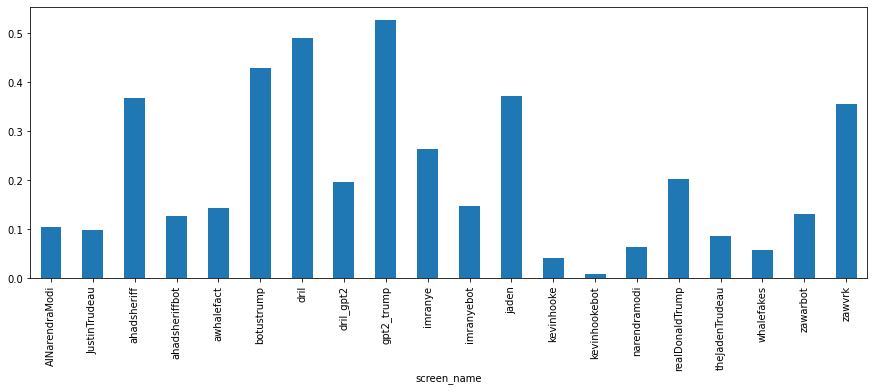

In [ ]:
plotErrorRatio(X_test_all, "label_log_reg")

,errors,num_samples,error_ratio
screen_name,,,
AINarendraModi,8,125,0.064000
DeepDrumpf,11,29,0.379310
GenePark,4,22,0.181818
GenePark_GPT2,6,22,0.272727
Gpt2Wint,1,2,0.500000
JustinTrudeau,1,51,0.019608
Musk_from_Mars,1,2,0.500000
Thorin,3,10,0.300000
UtilityLimb,3,4,0.750000


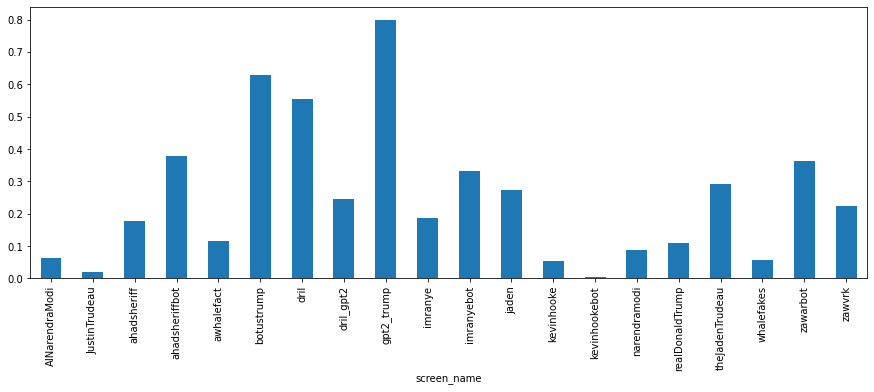

In [ ]:
plotErrorRatio(X_test_all, "label_rand_forest")